# 1. Імпорт бібліотек, встановлення сіду, налаштування pytorch на роботу на cuda

In [216]:
import torch
import random
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")

Using device: cuda
CUDA Device: NVIDIA GeForce RTX 2060


# 2. Завантаження FasionMNIST

In [217]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

data_path = '../data/lab1'
dataset = FashionMNIST(root=data_path, train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root=data_path, train=False, download=True, transform=transform)

# 3. Відображення декількох зображень з набору даних

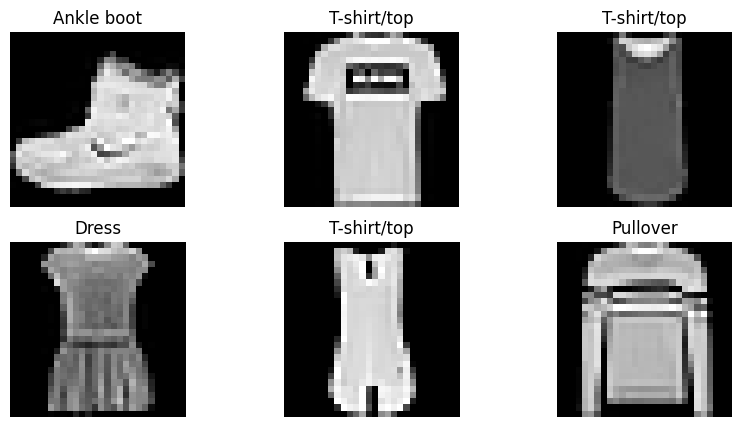

In [218]:
classes = dataset.classes
n_images = 6
rows, cols = 2, 3
figure = plt.figure(figsize=(10, 5))

for i in range(n_images):
    img, label = dataset[i]
    img = img.permute(1, 2, 0).numpy()
    ax = figure.add_subplot(rows, cols, i + 1)
    ax.imshow((img * 0.5) + 0.5, cmap='gray')
    ax.set_title(f"{classes[label]}")
    ax.axis('off')

plt.show()


# 4. Розділення даних на вибірки

In [219]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator())

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 5. Завантаження моделі GoogLeNet

In [220]:
model = models.googlenet(pretrained=True, aux_logits=True)

print(model)

/mnt/c/Users/HeyHo/Documents/GitHub/googlenet-fashionmnist/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/c/Users/HeyHo/Documents/GitHub/googlenet-fashionmnist/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

/mnt/c/Users/HeyHo/Documents/GitHub/googlenet-fashionmnist/venv/lib/python3.12/site-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


# 6. Налаштування моделі

In [221]:
model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
model.transform_input = False

num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)

model = model.to(device)
print(model)

GoogLeNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch2): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(192, 96, kernel_si

# 7. Визначення функції втрат і оптимізатора

In [222]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 8. Додаткові налаштування

In [223]:
def calculate_loss(outputs, targets, criterion):
    if not isinstance(outputs, tuple) or len(outputs) != 3:
        return criterion(outputs, targets)
    
    main_output, aux1_output, aux2_output = outputs
    
    if main_output.size(0) != targets.size(0):
        raise ValueError(f"Batch size mismatch: main_output {main_output.size()}, targets {targets.size()}")
    
    main_loss = criterion(main_output, targets)
    aux1_loss = criterion(aux1_output, targets)
    aux2_loss = criterion(aux2_output, targets)
    return main_loss + 0.3 * (aux1_loss + aux2_loss)

print(f"Auxiliary logits enabled: {model.aux_logits}")

Auxiliary logits enabled: True


# 9. Підготовка до навчання

In [224]:
model.train()
model.aux_logits = True

images, labels = next(iter(train_loader))

images, labels = images.to(device), labels.to(device)

outputs = model(images)

if isinstance(outputs, tuple):
    print(f"Main output shape: {outputs[0].shape}")
    print(f"Aux1 output shape: {outputs[1].shape}")
    print(f"Aux2 output shape: {outputs[2].shape}")
else:
    print(f"Main output shape: {outputs.shape}")


Main output shape: torch.Size([64, 10])
Aux1 output shape: torch.Size([64, 10])
Aux2 output shape: torch.Size([64, 10])


# 10. Навчання моделі

In [225]:
num_epochs = 25
batch_size = 64
learning_rate = 0.001
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def get_outputs_shape(outputs):
    if isinstance(outputs, tuple):
        return [o.shape for o in outputs]
    return outputs.shape

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        try:
            loss = calculate_loss(outputs, labels, criterion)
        except ValueError as e:
            print(f"Error in training: {e}")
            print(f"Outputs shape: {get_outputs_shape(outputs)}")
            print(f"Labels shape: {labels.shape}")
            raise
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        main_output = outputs[0] if isinstance(outputs, tuple) else outputs
        _, predicted = torch.max(main_output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            try:
                loss = calculate_loss(outputs, labels, criterion)
            except ValueError as e:
                print(f"Error in validation: {e}")
                print(f"Outputs shape: {get_outputs_shape(outputs)}")
                print(f"Labels shape: {labels.shape}")
                raise
            
            val_loss += loss.item()
            main_output = outputs[0] if isinstance(outputs, tuple) else outputs
            _, predicted = torch.max(main_output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)
    
    print(f'Epoch [{epoch+1}/{num_epochs}] - '
          f'Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}% - '
          f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%')

torch.save(model.state_dict(), '../models/lab1/googlenet_fashionmnist.pth')

Epoch [1/25] - Train Loss: 0.9125, Train Accuracy: 80.10% - Val Loss: 0.3785, Val Accuracy: 86.60%
Epoch [2/25] - Train Loss: 0.5957, Train Accuracy: 87.15% - Val Loss: 0.3370, Val Accuracy: 87.59%
Epoch [3/25] - Train Loss: 0.5334, Train Accuracy: 88.55% - Val Loss: 0.3187, Val Accuracy: 88.78%
Epoch [4/25] - Train Loss: 0.4816, Train Accuracy: 89.58% - Val Loss: 0.3037, Val Accuracy: 88.42%
Epoch [5/25] - Train Loss: 0.4435, Train Accuracy: 90.26% - Val Loss: 0.2833, Val Accuracy: 89.83%
Epoch [6/25] - Train Loss: 0.4034, Train Accuracy: 91.28% - Val Loss: 0.2778, Val Accuracy: 89.52%
Epoch [7/25] - Train Loss: 0.4285, Train Accuracy: 91.06% - Val Loss: 0.2642, Val Accuracy: 90.62%
Epoch [8/25] - Train Loss: 0.3361, Train Accuracy: 92.55% - Val Loss: 0.2615, Val Accuracy: 90.85%
Epoch [9/25] - Train Loss: 0.3228, Train Accuracy: 93.00% - Val Loss: 0.3310, Val Accuracy: 87.85%
Epoch [10/25] - Train Loss: 0.3365, Train Accuracy: 93.04% - Val Loss: 0.2852, Val Accuracy: 90.10%
Epoch [11

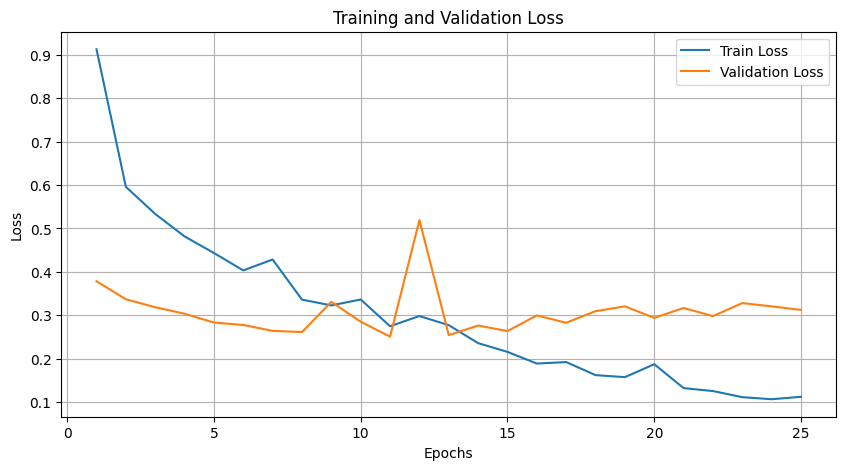

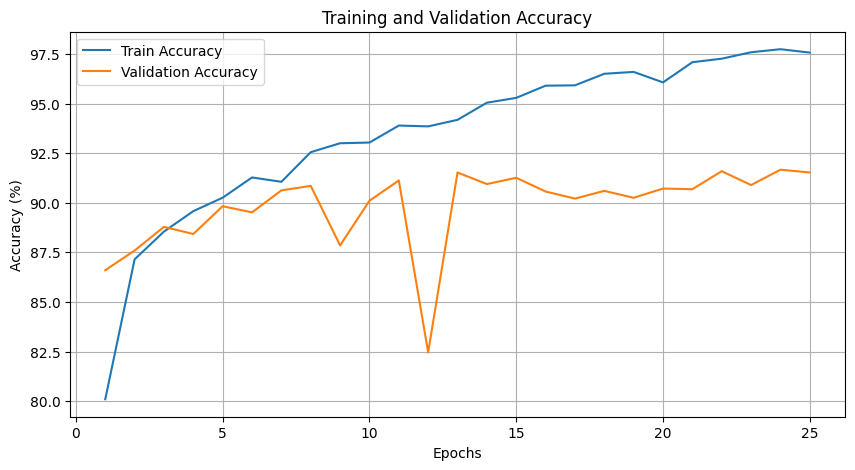

In [226]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [227]:
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        if isinstance(outputs, tuple):
            main_output = outputs[0]
        else:
            main_output = outputs
        
        _, predicted = torch.max(main_output, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 90.74%
